# 6. GO/STOP! - Object Detection 시스템 만들기  

## 6-1. 들어가며  

이번 시간에는 object detection 모델을 통해 주변에 다른 차나 사람이 가까이 있는지 확인한 후 멈출 수 있는 자율주행 시스템을 만들어보겠습니다. 아직 자율주행 시스템이 완전하지 않기에 위험한 상황은 운전자가 직접 운전할 수 있도록 하고, 판단이 어려운 상황은 멈추도록 설계합니다. 우리는 미니 자율주행 시스템을 만들어 볼 겁니다.  

전체 시스템 구성을 하기 위해 보조장치의 역할과 학습을 위한 데이터셋 전처리를 하겠습니다. Detection 모델을 학습시키기 위해 전체 파이프라인을 제작하는 것은 많은 시간이 필요해서 RetinaNet이라는 1-stage detector를 미리 학습시킨 라이브러리를 활용하자.  
이번 노드는 학습데이터 다운로드하는데 시간이 많이 걸린다.  

### 실습 목표  
----------------------------------------------------
  1. 바운딩 박스(bounding box) 데이터셋을 전처리할 수 있습니다.
  2. Object detection 모델을 학습할 수 있습니다.
  3. Detection 모델을 활용한 시스템을 만들 수 있습니다.
  
  
### 학습 내용
--------------------------------------------------------------------
  1. 자율주행 보조장치
  2. RetinaNet
  3. keras-retinanet
  4. 프로젝트: 자율주행 보조 시스템 만들기
  
  
### 준비물
---------------------------------------------------
터미널을 열어 경로 생성, 프로젝트를 위한 디렉토리 생성  
```
$ mkdir -p ~/aiffel/object_detection/data
```
(주의) [RetinaNet](https://github.com/fizyr/keras-retinanet) 홈페이지에 보면 tensorflow 2.3.0, tf.keras 2.4.0을 사용할 것을 권장하며, 그보다 높은 버전에서는 오류가 발생한다고 안내하고 있습니다. 만약 aiffel 가상환경에 설치된 Tensorflow 버전이 2.3.0보다 높을 경우 2.3.0에 맞추어 재설치하거나,
아니면 별도의 가상환경을 생성 후 해당 환경에서 jupyter notebook으로 실습을 진행할 것을 권합니다.  
```
$ pip uninstall tensorflow
$ pip install tensorflow==2.3.0
```  

프로젝트 디렉토리로 이동, 리포지토리 받고, 케라스 라이브러리를 aiffel 가상환경에 설치  
```
$ cd ~/aiffel/object_detection
$ git clone https://github.com/fizyr/keras-retinanet.git
$ cd keras-retinanet && python setup.py build_ext --inplace
```  
keras-retinanet도 pip로 인스톨
```
$ pip install tensorflow_datasets tqdm
$ pip install -r requirements.txt
$ pip install .
```  


In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

## 6-2. 자율주행 보조장치 (1) KITTI 데이터셋  
이번에 만들 자율주행 보조장치는 카메라에 사람이 가깝거나 차가 가까워져 탐지된 크기가 일정 이상일 때 멈춘다.  
<img src="KITTI.jpg">
자율주행 보조장치 object detection 요구사항
  1. 사람이 카메라에 감지되면 정지
  2. 차량이 일정 크기 이상으로 감지되면 정지
tensorflow_datasets에서 제공하는 KITTI 데이터셋 사용.  
KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D objecte detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있습니다.  
[KITTI데이터셋](http://www.cvlibs.net/datasets/kitti/)  
라이브러리를 불러와보자.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

아래 코드를 통해 KITTI 데이터셋 다운로드  
(주의) 이 데이터셋은 11GB가 넘어가는 대용량 데이터셋입니다. 다운로드 소요시간이 수시간 이상 지속될 수 있으니, 다운로드는 가급적 별도의 jupyter notebook에서 수행하시기를 권합니다.

In [3]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
import tensorflow as tf

print(tf.__version__)
# 1.14.0

tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
# True


2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

다운로드한 KITTI 데이터셋을 tfds.show_examples를 통해서 확인.  
우리가 일반적으로 보는 사진보다 광각으로 촬영된 사진을 볼 수 있다.

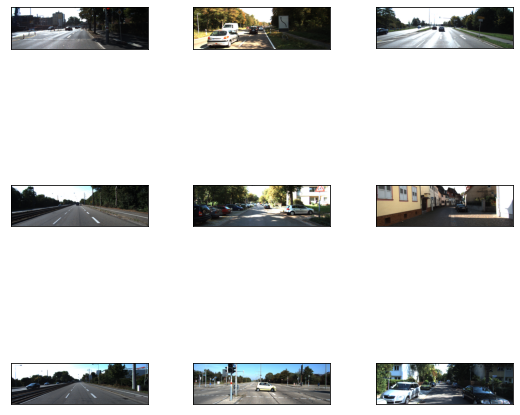

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

데이터 다운로드시 담아둔 ds_info에 불러온 데이터셋의 정보를 확인할 수 있다.
7481개의 학습 데이터, 711개의 평가용 데이터, 423개의 검증용 데이터로 구성.  
라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated.

In [6]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

## 6-3. 자율주행 보조장치 (2) 데이터 직접 확인하기  
데이터셋을 직접 확인해보자.  
ds_train.take(1)을 통해 데이터셋을 하나씩 뽑아볼 수 있는 TakeDataset을 얻을 수 있다.  
이렇게 뽑은 데이터에는 image등의 정보가 포함되어 있다.

In [7]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-1.41, -0.16, -0.33,  0.54, -0.52,  0.24, -0.63, -3.13, -2.92,
       -0.6 ], dtype=float32)>, 'bbox': <tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0.37932432, 0.35749182, 0.5407027 , 0.42800653],
       [0.46164864, 0.6927614 , 0.6078108 , 0.74281865],
       [0.46732432, 0.6404657 , 0.5972162 , 0.68215686],
       [0.4422973 , 0.42642158, 0.57391894, 0.44596404],
       [0.4868108 , 0.53743464, 0.578027  , 0.56710786],
       [0.42724323, 0.33937907, 0.570973  , 0.35838234],
       [0.38997298, 0.24528594, 0.53918916, 0.294616  ],
       [0.412973  , 0.29924837, 0.5487838 , 0.3186356 ],
       [0.42064863, 0.36306372, 0.5632162 , 0.37359476],
       [0.51813513, 0.83813727, 0.60572976, 0.928031  ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[1.5 , 1.78, 3.69],
       [1.74, 0.6 , 1.79],

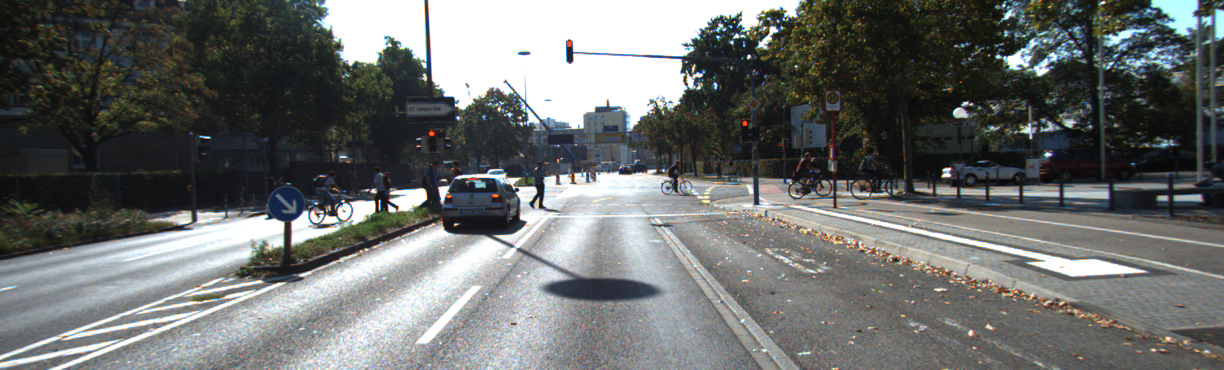

In [8]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

이미지와 라벨을 얻는 방법을 알았으니 이미지의 바운딩박스(bounding box, bbox)를 확인하려면 어떻게 해야 할까요?  
아래는 KITTI에서 제공하는 데이터셋 설명  
```
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
```  
<img src="원본.png">  
<img src="바운딩.png">  
[Pillow 라이브러리](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)의 ImageDraw[모듈](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)을 이용해 위의 그림처럼 바운딩 박스를 그려서 시각화해보자


width: 1224  height: 370
(10, 4)
[437.56998 229.65001 523.88    169.94   ]
[847.94 199.19 909.21 145.11]
[783.93    197.09    834.96    149.03001]
[521.94    206.34999 545.86    157.65   ]
[657.82 189.88 694.14 156.13]
[415.4     211.92    438.66    158.73999]
[300.22998 225.70999 360.61002 170.50002]
[366.28    217.2     390.00998 166.95   ]
[444.38998 214.36    457.28    161.61   ]
[1025.88     178.29001 1135.91     145.87999]
<PIL.Image.Image image mode=RGB size=1224x370 at 0x7F16F848B350>


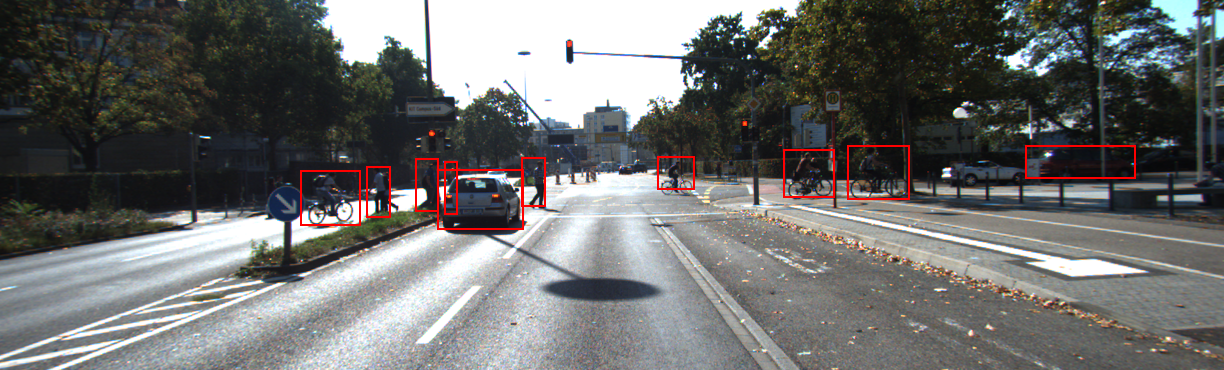

In [9]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())
# 결과 값을 보면 처음 2개가 (x1, y1), (x2, y2). 좌상단이 0,0 우하단이 +,+.

## 6-4. RetinaNet  
주요 참고 자료  
  * [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)
  * [Object Detection에 대하여_01: Overall Object detection flow](https://kimcando94.tistory.com/115)
  * [김홍배님의 Focal loss의 응용(Detection&Classification](https://www.slideshare.net/ssuser06e0c5/focal-loss-detection-classification)  

RetinaNet은 Focal Loss for Dense Object Detection 논문에서 공개한 detection 모델입니다.  
Detection 모델을 직접 만들기에는 많은 시간이 필요하기에 미리 모델을 구현한 라이브러리를 가져와서 커스텀 데이터셋에 학습시키고 빠르게 사용해보자.  

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있어서 이를 해결하기 위해 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network)를 적용한 네트워크를 사용합니다.  
<img src="Feature.png">  


### Focal Loss
---------------------------------------------------------------------------------------
Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었습니다. 여기서 그리드(grid)와 픽셀(pixel)이 혼란스러울 수 있겠는데, 위 그림 왼쪽 7x7 feature level에서는 한 픽셀이고, 오른쪽의 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field입니다
그림에서 보이는 것처럼 우리가 사용하는 이미지는 물체보다는 많은 배경을 학습하게 됩니다. 논문에서는 이를 해결하기 위해서 Loss를 개선하여 정확도를 높였습니다  
<img src="focal_loss.png">  
<img src="focalloss.png">
### FPN(Feature Pyramid Network)  
-------------------------------------------------------------------
[Upsampling참고](https://www.youtube.com/watch?v=nDPWywWRIRo)  


## 6-5. keras-retinanet 실습 (1) 데이터 포맷 변경  
[Keras RetinaNet](https://github.com/fizyr/keras-retinanet)  
케라스 라이브러리로 구현된 RetinaNet.  
현재 텐서플로우 2를 지원하는 리포지토리도 만들어져 있지만, 커스텀 데이터셋 학습방법이 공식문서로 제시되어 있지 않아 Keras RetinaNet 리포지토리를 이용해보겠습니다.  
우리가 가진 tensorflow_dataset의 KITTI 데이터셋을 사용해 Keras RetinaNet을 학습시키기 위해서는 라이브러리를 수정할 필요가 있다.  하지만 이보다 쉬운 방법은 해당 모델을 훈련할 수 있는 공통된 데이터셋 포맷인 CSV 형태로 모델을 변경하는 방법.  

### 클래스 및 바운딩 박스 정보 추출  
------------------------------------------------------------
우리는 tensorflow_data의 API를 통해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨 정보를 얻을 수 있었습니다.  
API를 통해 데이터를 추출, 이를 포맷팅하여 CSV형태로 한줄씩 저장해보자.  
한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 클래스 정보를 가지는 CSV파일을 작성하도록 코드를 작성하고, 이를 사용해 CSV파일을 생성. 우리가 생각하는 브레이크 시스템은 차와 사람을 구분해야 하는 점을 유의하자.  
```
데이터셋 포맷
# 데이터셋 형식
path/to/image.jpg,x1,y1,x2,y2,class_name

# Example
/data/imgs/img_001.jpg,837,346,981,456,cow
/data/imgs/img_002.jpg,215,312,279,391,cat
/data/imgs/img_002.jpg,22,5,89,84,bird
/data/imgs/img_003.jpg,,,,,
```  
```
CSV저장  
# 데이터셋 저장 시 참고
df_test = parse_dataset(ds_test, total=ds_info.splits['test'].num_examples)
df_test.to_csv('./kitti_test.csv', sep=',',index = False, header=False)
```
[tqdm](https://github.com/tqdm/tqdm)은 루프문의 상태에 따라 콘솔에 진행 상황 바를 표시할 수 있는 라이브러리입니다. 자세한 사항은 리포지토리를 참고하세요.  

In [10]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [13:51<00:00,  7.64it/s]


테스트 데이터셋에 대해서도 동일하게 parse_dataset()을 적용해서 dataframe을 생성해봅시다.

In [11]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:38<00:00,  7.25it/s]


### 클래스 맵핑  
------------------------------------------------------------------------
데이터 셋에서 클래스는 문자열로 표시되지만 모델에게 데이터를 알려줄 때는 숫자로 클래스를 표시해야 한다.  
어떤 클래스가 있고 각 클래스가 어떤 인덱스에 맵핑될지 정하고 학습한 후에 추론해야 추론할때에도 숫자로 나온 인덱스 정보를 클래스 이름으로 바꿔 해석할 수 있다.

In [12]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

## 6-6. keras-retinanet 실습(2) 셋팅  
먼저 터미널을 열어주세요. 미리 설치해 둔 케라스 및 Keras RetinaNet 리포지토리를 사용하겠습니다.

아직 설치하지 않으셨다면, 0번 스텝의 '준비물' 항목을 참고하여 환경을 셋팅해 주세요.

준비가 완료되었다면 아래 스크립트를 참고하셔서 위에서 변환한 데이터셋으로 학습을 시작해 주세요. 학습이 잘 되기 위해서는 환경에 따라 batch_size나 worker, epoch를 조절해야 합니다.

훈련 이미지 크기 또는 batch_size가 너무 크면 GPU에서 out-of-memory 에러가 날 수 있으니 적절히 조정해 주세요. 원 개발자는 8G 메모리도 RetinaNet을 훈련시키기에는 부족할 수 있다고 설명합니다 (참고).

In [13]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-27 17:24:53.131592: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 17:24:54.221014: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-27 17:24:54.224958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 17:24:54.225344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 17:24:54.225366: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 17:24:54.229179: I tensorflow/stream_executor/platform

bn4c_branch2b (BatchNormalizati (None, None, None, 2 1024        res4c_branch2b[0][0]             
__________________________________________________________________________________________________
res4c_branch2b_relu (Activation (None, None, None, 2 0           bn4c_branch2b[0][0]              
__________________________________________________________________________________________________
res4c_branch2c (Conv2D)         (None, None, None, 1 262144      res4c_branch2b_relu[0][0]        
__________________________________________________________________________________________________
bn4c_branch2c (BatchNormalizati (None, None, None, 1 4096        res4c_branch2c[0][0]             
__________________________________________________________________________________________________
res4c (Add)                     (None, None, None, 1 0           bn4c_branch2c[0][0]              
                                                                 res4b_relu[0][0]                 
__________

Epoch 1/50
2021-04-27 17:25:04.700265: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-04-27 17:25:06.170649: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-04-27 17:25:07.239992: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
195/195 [==============================] - ETA: 0s - loss: 3.4824 - regression_loss: 2.6676 - classification_loss: 0.8148
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
2021-04-27 17:26:11.036406: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 18874368 exceeds 10% of free system memory.
2021-04-27 17:26:11.387966: W tensorflow/core/framework/cpu_allocator_impl.cc

195/195 [==============================] - ETA: 0s - loss: 1.5028 - regression_loss: 1.1539 - classification_loss: 0.3489
Epoch 00015: saving model to ./snapshots/resnet50_csv_15.h5
195/195 [==============================] - 60s 309ms/step - loss: 1.5028 - regression_loss: 1.1539 - classification_loss: 0.3489
Epoch 16/50
195/195 [==============================] - ETA: 0s - loss: 1.3926 - regression_loss: 1.0794 - classification_loss: 0.3132
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
195/195 [==============================] - 60s 309ms/step - loss: 1.3926 - regression_loss: 1.0794 - classification_loss: 0.3132
Epoch 17/50
195/195 [==============================] - ETA: 0s - loss: 1.4925 - regression_loss: 1.1598 - classification_loss: 0.3327
Epoch 00017: saving model to ./snapshots/resnet50_csv_17.h5
195/195 [==============================] - 60s 308ms/step - loss: 1.4925 - regression_loss: 1.1598 - classification_loss: 0.3327
Epoch 18/50
195/195 [======================

195/195 [==============================] - ETA: 0s - loss: 1.0470 - regression_loss: 0.8032 - classification_loss: 0.2438
Epoch 00031: saving model to ./snapshots/resnet50_csv_31.h5
195/195 [==============================] - 60s 309ms/step - loss: 1.0470 - regression_loss: 0.8032 - classification_loss: 0.2438
Epoch 32/50
195/195 [==============================] - ETA: 0s - loss: 1.0076 - regression_loss: 0.7672 - classification_loss: 0.2404
Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5
195/195 [==============================] - 60s 309ms/step - loss: 1.0076 - regression_loss: 0.7672 - classification_loss: 0.2404
Epoch 33/50
195/195 [==============================] - ETA: 0s - loss: 1.0487 - regression_loss: 0.8006 - classification_loss: 0.2481
Epoch 00033: saving model to ./snapshots/resnet50_csv_33.h5
195/195 [==============================] - 60s 309ms/step - loss: 1.0487 - regression_loss: 0.8006 - classification_loss: 0.2481
Epoch 34/50
195/195 [======================

195/195 [==============================] - ETA: 0s - loss: 1.0910 - regression_loss: 0.8391 - classification_loss: 0.2519
Epoch 00047: saving model to ./snapshots/resnet50_csv_47.h5

Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.999998977483754e-17.
195/195 [==============================] - 60s 309ms/step - loss: 1.0910 - regression_loss: 0.8391 - classification_loss: 0.2519
Epoch 48/50
195/195 [==============================] - ETA: 0s - loss: 1.0960 - regression_loss: 0.8283 - classification_loss: 0.2677
Epoch 00048: saving model to ./snapshots/resnet50_csv_48.h5
195/195 [==============================] - 60s 310ms/step - loss: 1.0960 - regression_loss: 0.8283 - classification_loss: 0.2677
Epoch 49/50
195/195 [==============================] - ETA: 0s - loss: 1.1081 - regression_loss: 0.8432 - classification_loss: 0.2649
Epoch 00049: saving model to ./snapshots/resnet50_csv_49.h5

Epoch 00049: ReduceLROnPlateau reducing learning rate to 9.999998845134856e-18.
195/195 [=

In [14]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-27 18:16:17.322774: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 18:16:18.981646: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-27 18:16:19.004129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 18:16:19.004532: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 18:16:19.004555: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 18:16:19.007656: I tensorflow/stream_executor/platform

## 6-7. keras-retinanet 실습 (3) 시각화  
이제 위에서 변환한 모델을 load하고 추론 및 시각화를 해보세요!

아래에 load된 모델을 통해 추론을 하고 시각화를 하는 함수를 작성해 주세요. 일정 점수 이하는 경우를 제거해야 함을 유의해 주세요.

아래에서 몇 가지 테스트 셋을 받아 사용해 보세요.
```
$ mkdir -p ~/aiffel/object_detection/test_set
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
$ mv test_set.zip ~/aiffel/object_detection/test_set
$ cd ~/aiffel/object_detection/test_set && unzip test_set.zip
```

In [15]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[593.7499  175.19109 624.85406 205.98747]
[191.14317 137.4618  340.87317 231.53294]


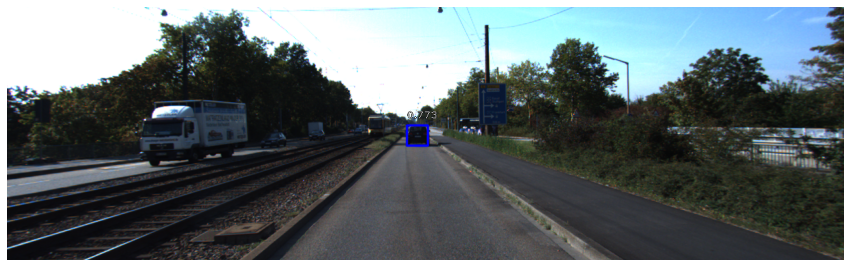

([0], [array([593.7499 , 175.19109, 624.85406, 205.98747], dtype=float32)])

In [33]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)
    class_list = []
    bbox_list = []
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue 차량
        1: (255, 0, 0) # red 사람
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
            class_list.append(label)
            bbox_list.append(box)
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            
    
    return class_list, bbox_list
    
inference_on_image(model, img_path=img_path)

[771.5899  150.94734 843.398   320.49634]
[771.1441  155.43542 841.36884 315.16083]


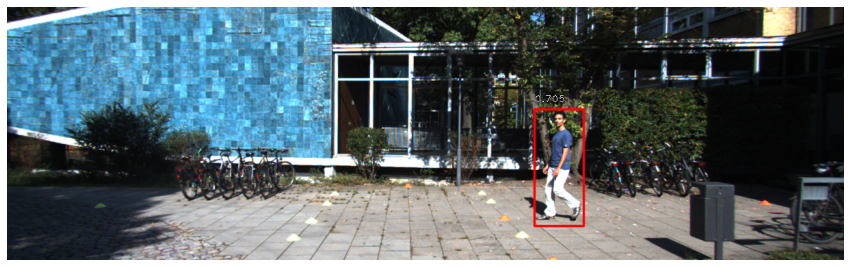

In [24]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

## 6-8. 프로젝트: 자율주행 보조 시스템 만들기  

### 1. 자율주행 시스템 만들기  
---------------------------------------------------------------
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.  
  * 입력으로 이미지 경로를 받습니다.
  * 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
  * 조건은 다음과 같습니다.
     * 사람이 한 명 이상 있는 경우
     * 차량의 크기(width or height)가 300px이상인 경우  

```
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"

print(self_drive_assist(img_path))
```

[  3.9625509 148.38345   160.94997   306.21268  ]
[500.3169  178.11214 553.733   216.25374]


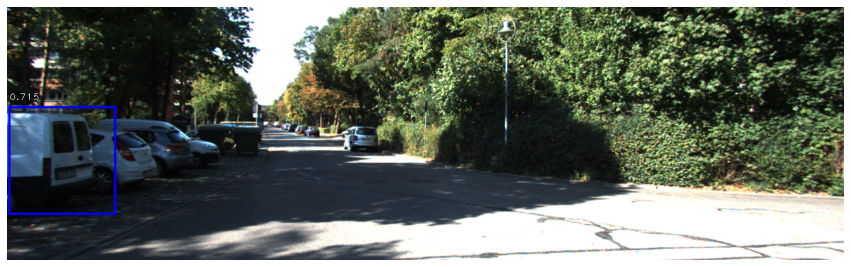

Go


In [57]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/006483.png'
def self_drive_assist(img_path, size_limit=300):
    answer = "Go"
    label, bbox = inference_on_image(model, img_path=img_path)
    if label.count([1]) > 0:
        answer = "Stop"
        return answer
    for i in bbox:
        if i[2] - i[0] > size_limit or i[3] - i[1] > size_limit:
            answer = "Stop"
            break
    return answer
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"
print(self_drive_assist(img_path))

### 2. 자율주행 시스템 평가하기  
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.  
```
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)
```


[771.5899  150.94734 843.398   320.49634]
[771.1441  155.43542 841.36884 315.16083]


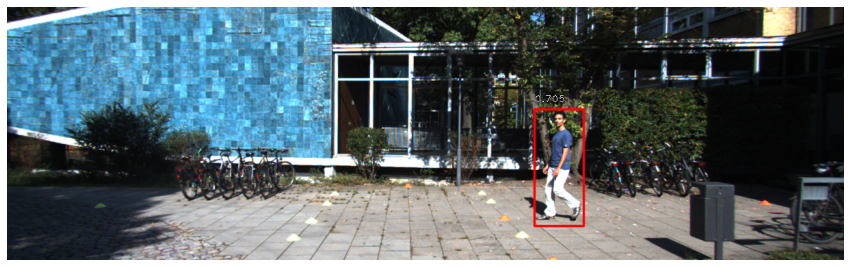

[411.34546 158.61183 499.22116 329.58887]
[412.1464  157.2508  499.37744 321.75906]


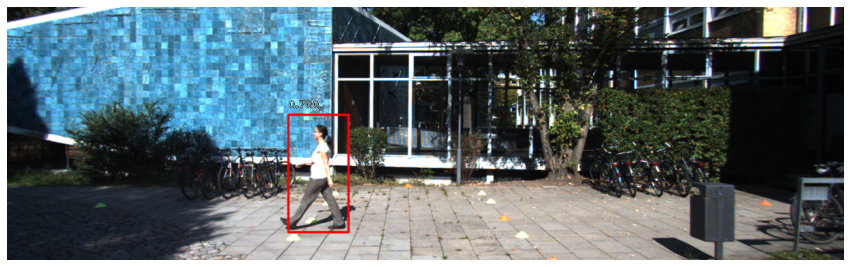

[  2.3087249 204.75436   296.43744   369.12827  ]
[753.6206  162.23717 882.9721  210.24751]


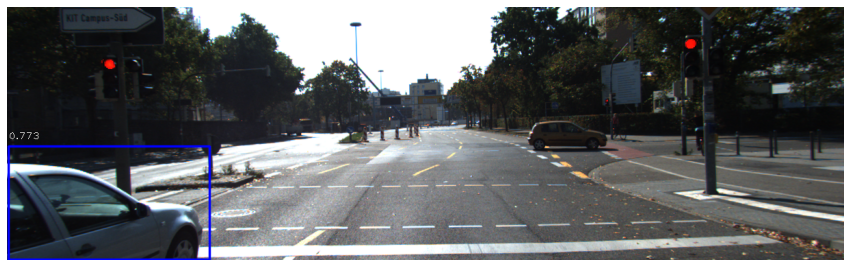

[ 728.45844    36.124897 1116.9532    363.15094 ]
[ 85.9192  156.41702 372.7264  308.14648]


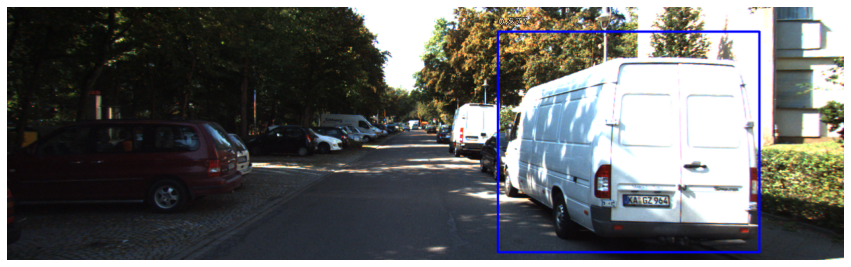

[ 881.44525  172.78545 1238.8625   370.52237]
[734.2619  167.54913 861.6568  243.70436]


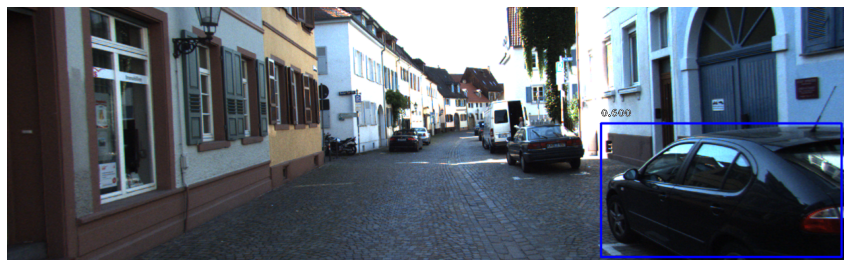

[593.7499  175.19109 624.85406 205.98747]
[191.14317 137.4618  340.87317 231.53294]


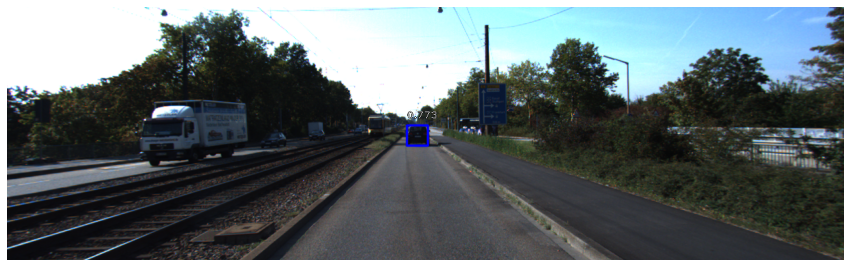

[629.02167 176.30286 667.9647  211.43365]
[517.35236 178.92902 569.30396 213.37335]


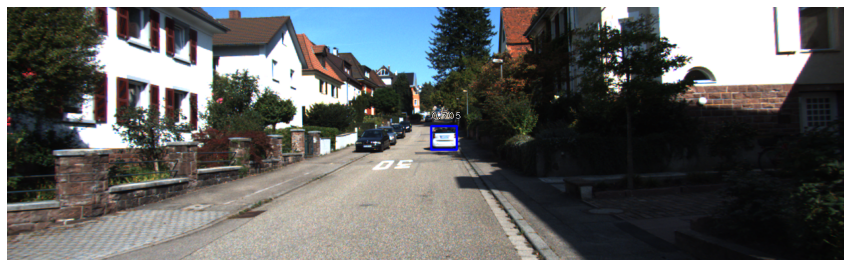

[805.3551  146.30692 886.1002  176.50583]
[541.16034 169.1882  567.7168  190.03532]


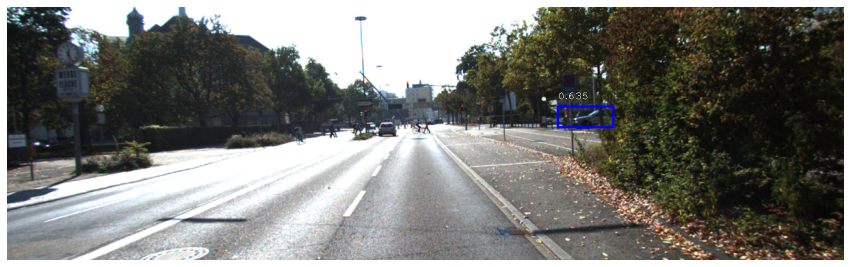

[698.4589  171.73598 794.0376  250.81903]


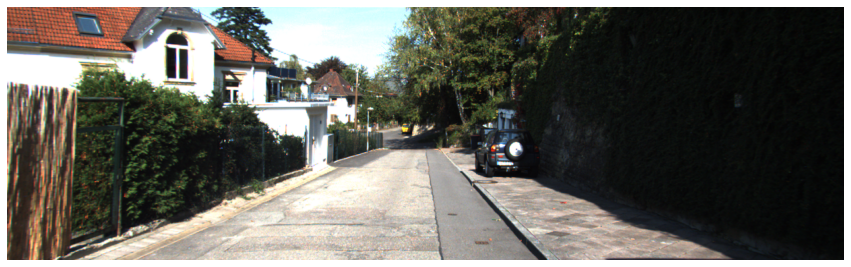

[  9.767607 191.18846  238.25746  305.7071  ]


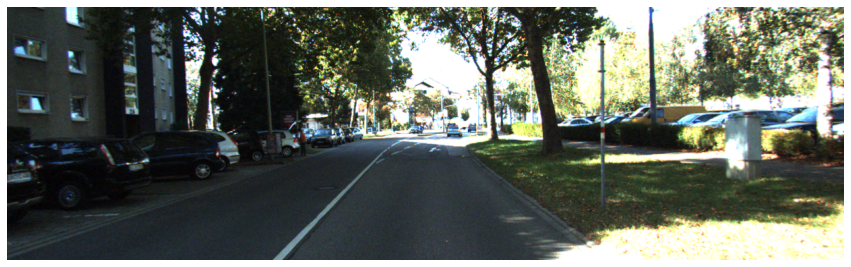

90점입니다.


In [56]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)